In [37]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import joblib
import requests
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from src.libs.data_preprocessing_meli import data_handling as dh
from src.libs.modelling_meli import DataModelling as dm

In [2]:
countries_req=requests.get('https://api.mercadolibre.com/sites')
countries=countries_req.json()
country_selected=dh.filter_list_of_dicts_by_string_in_key(list_of_dicts=countries,key_name='name',string_value='Col')
print(country_selected)

[{'default_currency_id': 'COP', 'id': 'MCO', 'name': 'Colombia'}]


In [3]:
country_id=country_selected[0].get('id')
cats = requests.get(f'https://api.mercadolibre.com/sites/{country_id}/categories')
categorias=cats.json()
cat_selected=dh.filter_list_of_dicts_by_string_in_key(list_of_dicts=categorias,key_name='name',string_value='Celular')
cat_id = cat_selected[0].get('id')
tot_items_cat=requests.get(f'https://api.mercadolibre.com/categories/{cat_id}').json().get("total_items_in_this_category")
print(cat_selected[0],f"total items category: {tot_items_cat}")

{'id': 'MCO1051', 'name': 'Celulares y Teléfonos'} total items category: 845091


In [4]:
# df_items=dh.get_items_data(tot_items_cat=tot_items_cat, cat_id=cat_id,country_id=country_id)
# df_items.to_csv('MELI_items.csv',sep=';',index=False)

In [5]:
df_items=pd.read_csv('MELI_items.csv',sep=';')
print(df_items.shape)
df_items.head()

(1049, 85)


,item_id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller_reputation.metrics.claims.excluded.real_value,seller_reputation.metrics.claims.excluded.real_rate,seller_reputation.metrics.cancellations.excluded.real_value,seller_reputation.metrics.cancellations.excluded.real_rate,quantity,amount,rate,currency_id.1
0,MCO877397746,Xiaomi Redmi Note 11s Dual Sim 128 Gb Gris Gra...,new,670312-MLA52131542566_102022,MCO18983362,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,27636.11,0,COP
1,MCO1349872512,Xiaomi Redmi Note 12 Pro+ 5g Dual Sim 256 Gb O...,new,933725-MLA54384359928_032023,MCO22263907,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,48608.33,0,COP
2,MCO888584026,Xiaomi Redmi Note 11 (snapdragon) Dual Sim 128...,new,805485-MLA52140683184_102022,MCO18924350,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-n...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,20552.78,0,COP
3,MCO1518207822,Samsung Galaxy A22 5g Dual Sim 128 Gb Green 4 ...,new,678688-MLA48697047544_122021,MCO18360201,gold_special,https://www.mercadolibre.com.co/samsung-galaxy...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,21572.92,0,COP
4,MCO1022679002,Xiaomi Redmi 9a Dual Sim 32 Gb Azul Celeste 2 ...,new,871145-MLA48765111953_012022,MCO15927745,gold_special,https://www.mercadolibre.com.co/xiaomi-redmi-9...,buy_it_now,MCO,MCO1055,...,NaN,NaN,NaN,NaN,NaN,NaN,36,9532.25,0,COP


In [6]:
df = (
    df_items
    .assign(
        discount=lambda df: np.where(((df['price'] < df['original_price']) & (df.original_price.notna())), 100 * (1 - df['price'] / df['original_price']), 0)
    )
    .assign(
        registration_date=lambda df: pd.to_datetime(df['registration_date']).dt.strftime('%Y-%m-%d'),
        years_antiquity=lambda df: (dt.datetime.today() - pd.to_datetime(df['registration_date'])).dt.days / 365.25
    )
    .groupby(["seller_id", "seller_reputation.power_seller_status", 'seller_reputation.level_id', 
                'registration_date', 'years_antiquity', 'seller_reputation.metrics.sales.period'], dropna=False)
    .agg(
        n_items=('item_id', 'count'),
        n_subcategories=("category_id", 'nunique'),
        sold_items=('sold_quantity', 'sum'),
        mean_intallments=('quantity', 'mean'),
        q10_discount=('discount', lambda x: x.quantile(0.1)),
        q50_discount=('discount', lambda x: x.quantile(0.5)),
        q90_discount=('discount', lambda x: x.quantile(0.9)),
        total_transactions=('seller_reputation.transactions.total', 'sum'),
        completed_transactions=('seller_reputation.transactions.completed', 'sum'),
        canceled_transactions=('seller_reputation.transactions.canceled', 'sum'),
        negative_rating=('seller_reputation.transactions.ratings.negative', 'mean'),
        neutral_rating=('seller_reputation.transactions.ratings.neutral', 'mean'),
        positive_rating=('seller_reputation.transactions.ratings.positive', 'mean'),
        total_claims=('seller_reputation.metrics.claims.value', 'sum'),
        total_delayed_shipments=('seller_reputation.metrics.delayed_handling_time.value', 'sum'),
        total_cancellations=('seller_reputation.metrics.cancellations.value', 'sum')
    )
    .reset_index(drop=False)
    .assign(**{'seller_reputation.power_seller_status': lambda df: np.where(df['seller_reputation.power_seller_status'].notna(), df['seller_reputation.power_seller_status'], 'Not_medal')})
    .assign(**{'seller_reputation.level_id': lambda df: np.where(df['seller_reputation.level_id'].notna(), df['seller_reputation.level_id'], '0_Not_type')})
    .merge(dh.summarise_categoric_variable(df_items, row_name='seller_id', column_name='listing_type_id'), how='left', on='seller_id')
    .reset_index(drop=True)
    .drop(columns=['registration_date'])
)

df_sellers_raw = df.rename(columns=dict(zip([c for c in df.columns if '.' in c], [c.replace('.', '+') for c in df.columns if '.' in c])))

([<matplotlib.patches.Wedge at 0x2c9bf7c9790>,
 [Text(0.20834495323104638, 1.08008906135705, 'Not_medal'),
  Text(-1.0916078674141414, -0.13561808065132958, 'gold'),
  Text(-0.3291249986010824, -1.0496078959763202, 'platinum'),
  Text(0.8965311932794858, -0.6373631770638003, 'silver')],
 [Text(0.11364270176238891, 0.5891394880129363, '44%'),
  Text(-0.5954224731349862, -0.07397349853708884, '16%'),
  Text(-0.1795227265096813, -0.5725133978052654, '20%'),
  Text(0.48901701451608315, -0.3476526420348001, '20%')])

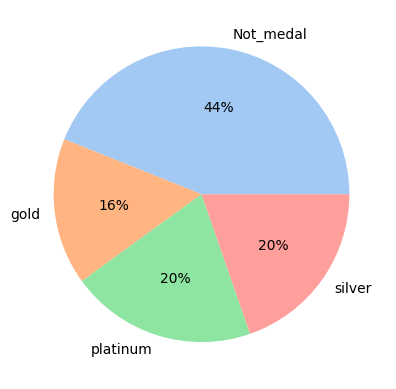

In [127]:
sellers_mercadolider=pd.DataFrame(100*df_sellers_raw.groupby(['seller_reputation+power_seller_status'])['seller_id'].count()/df_sellers_raw.groupby(['seller_reputation+power_seller_status'])['seller_id'].count().sum()).reset_index(drop=False)
plt.pie(data=sellers_mercadolider,x='seller_id',labels=sellers_mercadolider['seller_reputation+power_seller_status'],colors=sns.color_palette('pastel')[0:4],autopct='%.0f%%')

In [128]:
sellers_mercadolider

,seller_reputation+power_seller_status,seller_id
0,Not_medal,43.934426
1,gold,16.065574
2,platinum,20.327869
3,silver,19.672131


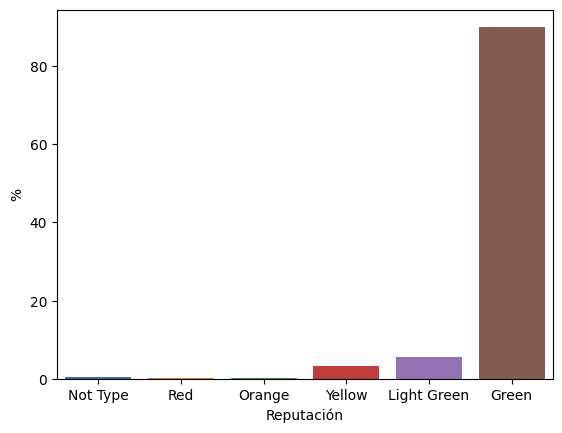

In [129]:
sellers_reputation=pd.DataFrame(100*df_sellers_raw.groupby(['seller_reputation+level_id'])['seller_id'].count()/df_sellers_raw.groupby(['seller_reputation+level_id'])['seller_id'].count().sum()).reset_index(drop=False)
ax=sns.barplot(x='seller_reputation+level_id',y='seller_id',data=sellers_reputation)
ax.set_xlabel('Reputación')
ax.set_ylabel('%')
plt.xticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.show()

In [130]:
sellers_reputation

,seller_reputation+level_id,seller_id
0,0_Not_type,0.655738
1,1_red,0.327869
2,2_orange,0.327869
3,3_yellow,3.278689
4,4_light_green,5.573770
5,5_green,89.836066


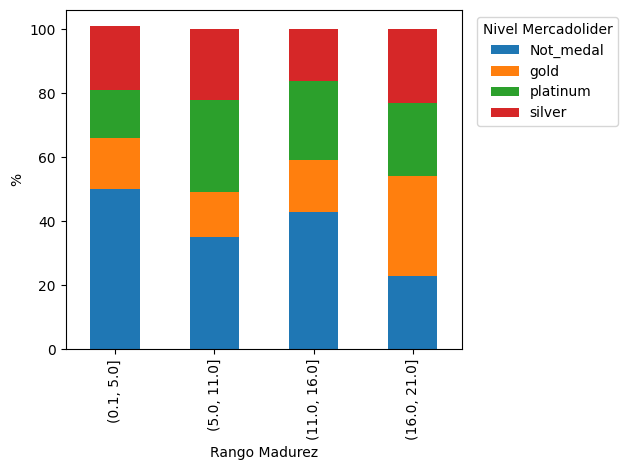

In [131]:
madurez_mercadolider=100*pd.crosstab(pd.cut(df_sellers_raw['years_antiquity'],bins=4,precision=0),df_sellers_raw['seller_reputation+power_seller_status'],normalize='index').round(2)
ax=madurez_mercadolider.plot.bar(stacked=True)
plt.xlabel('Rango Madurez')
plt.ylabel('%')
ax.legend(title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [132]:
madurez_mercadolider

seller_reputation+power_seller_status,Not_medal,gold,platinum,silver
years_antiquity,,,,
"(0.1, 5.0]",50.0,16.0,15.0,20.0
"(5.0, 11.0]",35.0,14.0,29.0,22.0
"(11.0, 16.0]",43.0,16.0,25.0,16.0
"(16.0, 21.0]",23.0,31.0,23.0,23.0


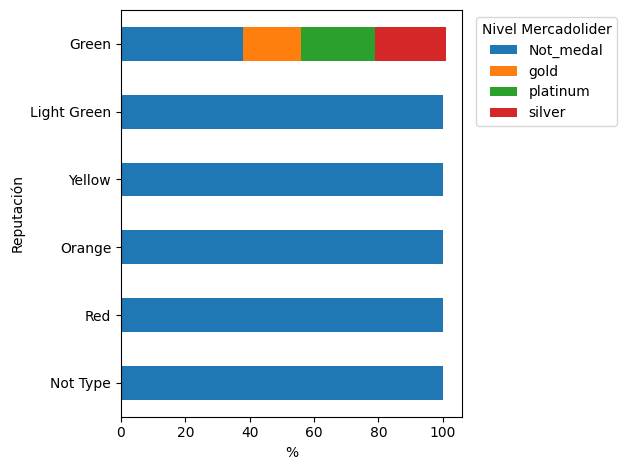

In [133]:
mercadolider_reputacion=100*dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+level_id','seller_reputation+power_seller_status').round(2)
ax=mercadolider_reputacion.plot.barh(stacked=True)
plt.ylabel('Reputación')
plt.yticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.xlabel('%')
ax.legend(title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [134]:
mercadolider_reputacion

,seller_reputation+level_id,Not_medal,gold,platinum,silver
0,0_Not_type0_Not_type0_Not_type0_Not_type0_Not_...,100.0,0.0,0.0,0.0
1,1_red1_red1_red1_red1_red1_red1_red1_red1_red1...,100.0,0.0,0.0,0.0
2,2_orange2_orange2_orange2_orange2_orange2_oran...,100.0,0.0,0.0,0.0
3,3_yellow3_yellow3_yellow3_yellow3_yellow3_yell...,100.0,0.0,0.0,0.0
4,4_light_green4_light_green4_light_green4_light...,100.0,0.0,0.0,0.0
5,5_green5_green5_green5_green5_green5_green5_gr...,38.0,18.0,23.0,22.0


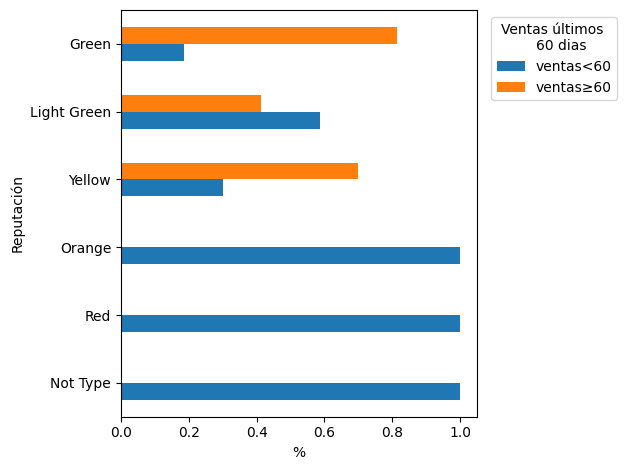

In [149]:
reputacion_periodo=dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+level_id','seller_reputation+metrics+sales+period')
ax=reputacion_periodo.plot.barh(stacked=False)
plt.ylabel('Reputación')
plt.yticks(ticks=[0,1,2,3,4,5],labels=['Not Type','Red','Orange','Yellow','Light Green','Green'],rotation='horizontal')
plt.xlabel('%')
ax.legend(['ventas<60','ventas≥60'],title='Ventas últimos \n        60 dias', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

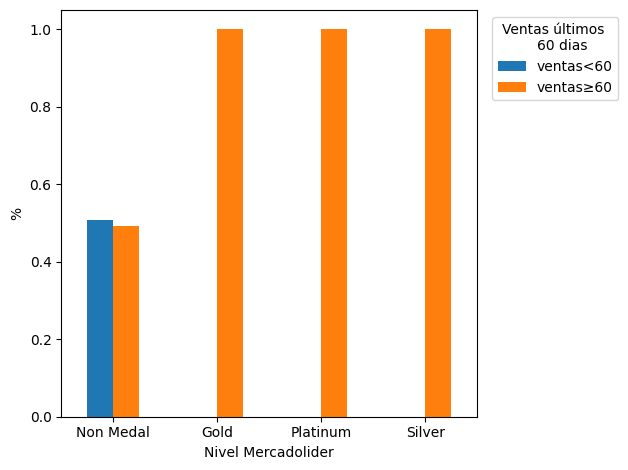

In [148]:
mercadolider_periodo=dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+power_seller_status','seller_reputation+metrics+sales+period')
ax=mercadolider_periodo.plot.bar(stacked=False)
plt.xlabel('Nivel Mercadolider')
plt.xticks(ticks=[0,1,2,3],labels=['Non Medal','Gold','Platinum','Silver'],rotation='horizontal')
plt.ylabel('%')
ax.legend(['ventas<60','ventas≥60'],title='Ventas últimos \n        60 dias', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
mercadolider_periodo

,seller_reputation+power_seller_status,365 days,60 days
0,Not_medal,0.507463,0.492537
1,gold,0.000000,1.000000
2,platinum,0.000000,1.000000
3,silver,0.000000,1.000000


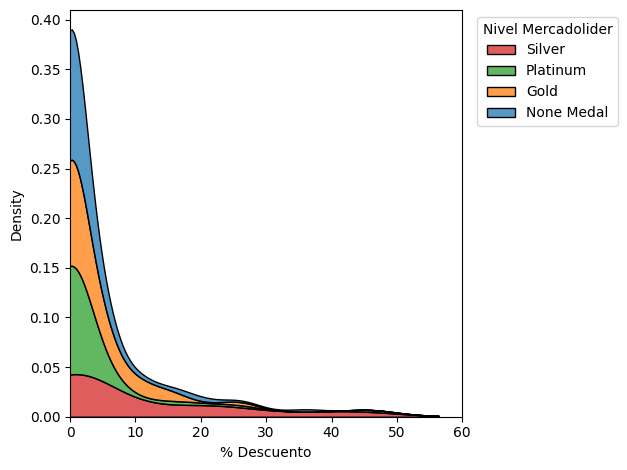

In [173]:
ax=sns.kdeplot(data=df_sellers_raw,x='q90_discount',hue='seller_reputation+power_seller_status',multiple='stack',common_norm=False)
ax.set_xlim(0,60)
plt.xlabel('% Descuento')
ax.legend(['Silver','Platinum','Gold','None Medal'],title='Nivel Mercadolider', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
df_sellers=dh.transform_df_items(df_items=df_items)
print(df_sellers.shape)
df_sellers.head()

(305, 32)


,seller_id,years_antiquity,n_items,n_subcategories,sold_items,mean_intallments,q10_discount,q50_discount,q90_discount,total_transactions,...,seller_reputation+power_seller_status-platinum,seller_reputation+power_seller_status-silver,seller_reputation+level_id-0_Not_type,seller_reputation+level_id-1_red,seller_reputation+level_id-2_orange,seller_reputation+level_id-3_yellow,seller_reputation+level_id-4_light_green,seller_reputation+level_id-5_green,seller_reputation+metrics+sales+period-365 days,seller_reputation+metrics+sales+period-60 days
0,1066358,16.599589,1,1,2,12.0,0.000000,0.00000,0.000000,1183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3637758,16.372348,1,1,5,36.0,0.000000,0.00000,0.000000,3083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,4944181,11.356605,1,1,0,36.0,10.000000,10.00000,10.000000,357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6818277,16.216290,1,1,5,36.0,0.000000,0.00000,0.000000,364,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,8019088,21.347023,2,1,51,36.0,0.500006,2.50003,4.500055,5502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [8]:
df_clust=df_sellers[[c for c in df_sellers.columns if c not in ['seller_id']]]

In [9]:
scaler=MinMaxScaler()
scaler.fit(df_clust)
joblib.dump(scaler,'scaler.sav')

['scaler.sav']

In [10]:
scaler=joblib.load('scaler.sav')

In [11]:
df_scaled=pd.DataFrame(scaler.transform(df_clust),columns=scaler.get_feature_names_out()).set_index(df_sellers.seller_id)
df_scaled.head()

,years_antiquity,n_items,n_subcategories,sold_items,mean_intallments,q10_discount,q50_discount,q90_discount,total_transactions,completed_transactions,...,seller_reputation+power_seller_status-platinum,seller_reputation+power_seller_status-silver,seller_reputation+level_id-0_Not_type,seller_reputation+level_id-1_red,seller_reputation+level_id-2_orange,seller_reputation+level_id-3_yellow,seller_reputation+level_id-4_light_green,seller_reputation+level_id-5_green,seller_reputation+metrics+sales+period-365 days,seller_reputation+metrics+sales+period-60 days
seller_id,,,,,,,,,,,,,,,,,,,,,
1066358,0.776633,0.00,0.0,0.000154,0.0,0.000000,0.000000,0.000000,0.001194,0.001178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3637758,0.765941,0.00,0.0,0.000385,1.0,0.000000,0.000000,0.000000,0.003117,0.003111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4944181,0.529950,0.00,0.0,0.000000,1.0,0.285714,0.248876,0.208969,0.000358,0.000342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6818277,0.758598,0.00,0.0,0.000385,1.0,0.000000,0.000000,0.000000,0.000365,0.000375,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8019088,1.000000,0.02,0.0,0.003923,1.0,0.014286,0.062220,0.094037,0.005565,0.005385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


{'elbow': 7,
 'silhoutte': 15,
 'similitud_ Davies-Bouldin': 11,
 'Cohesion_calinski-harabasz': 7}

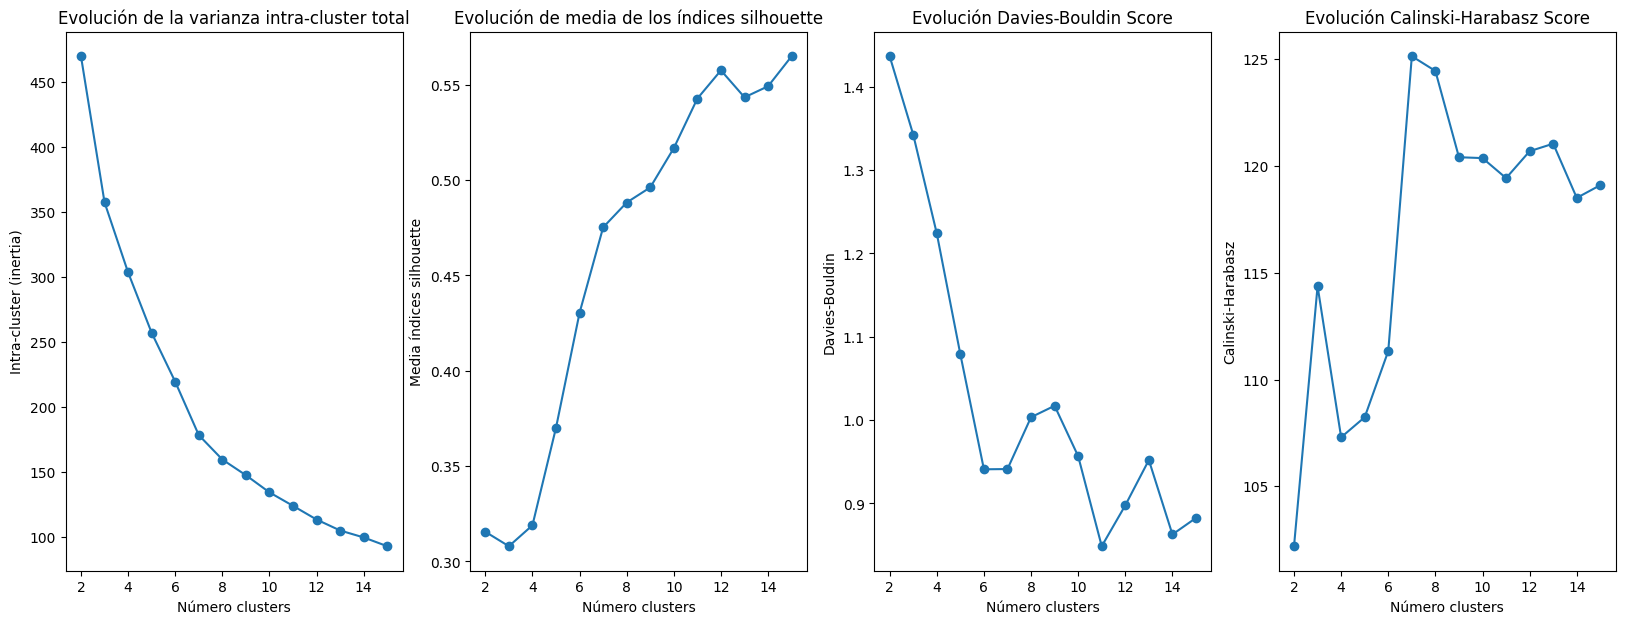

In [12]:
km_metricas=dm.kmeans_clustering_analysis(df_scaled=df_scaled,range_n_clusters=range(2,16))
km_metricas

{'silhoutte': 15,
 'similitud_ Davies-Bouldin': 12,
 'Cohesion_calinski-harabasz': 9}

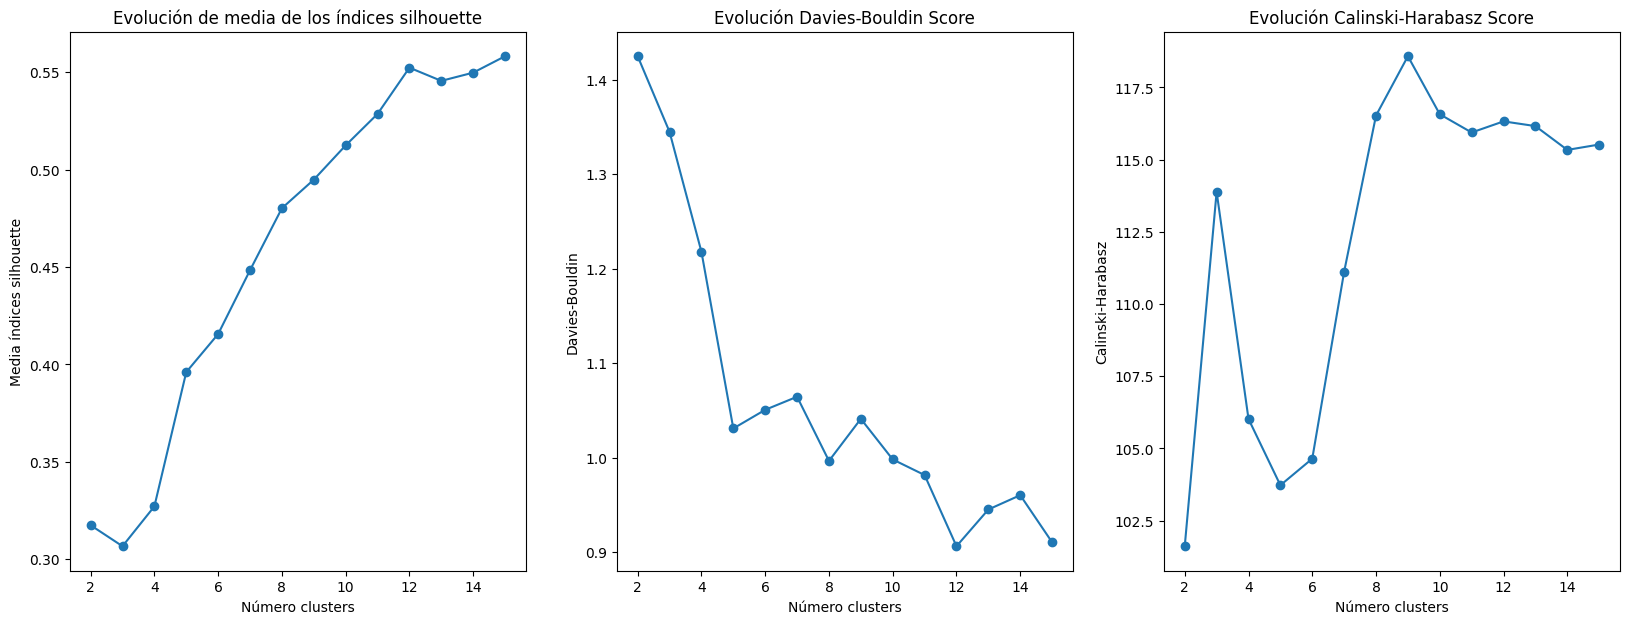

In [13]:
hier_metrics=dm.hierarchical_clustering_analysis(df_scaled=df_scaled,range_n_clusters=range(2,16))
hier_metrics

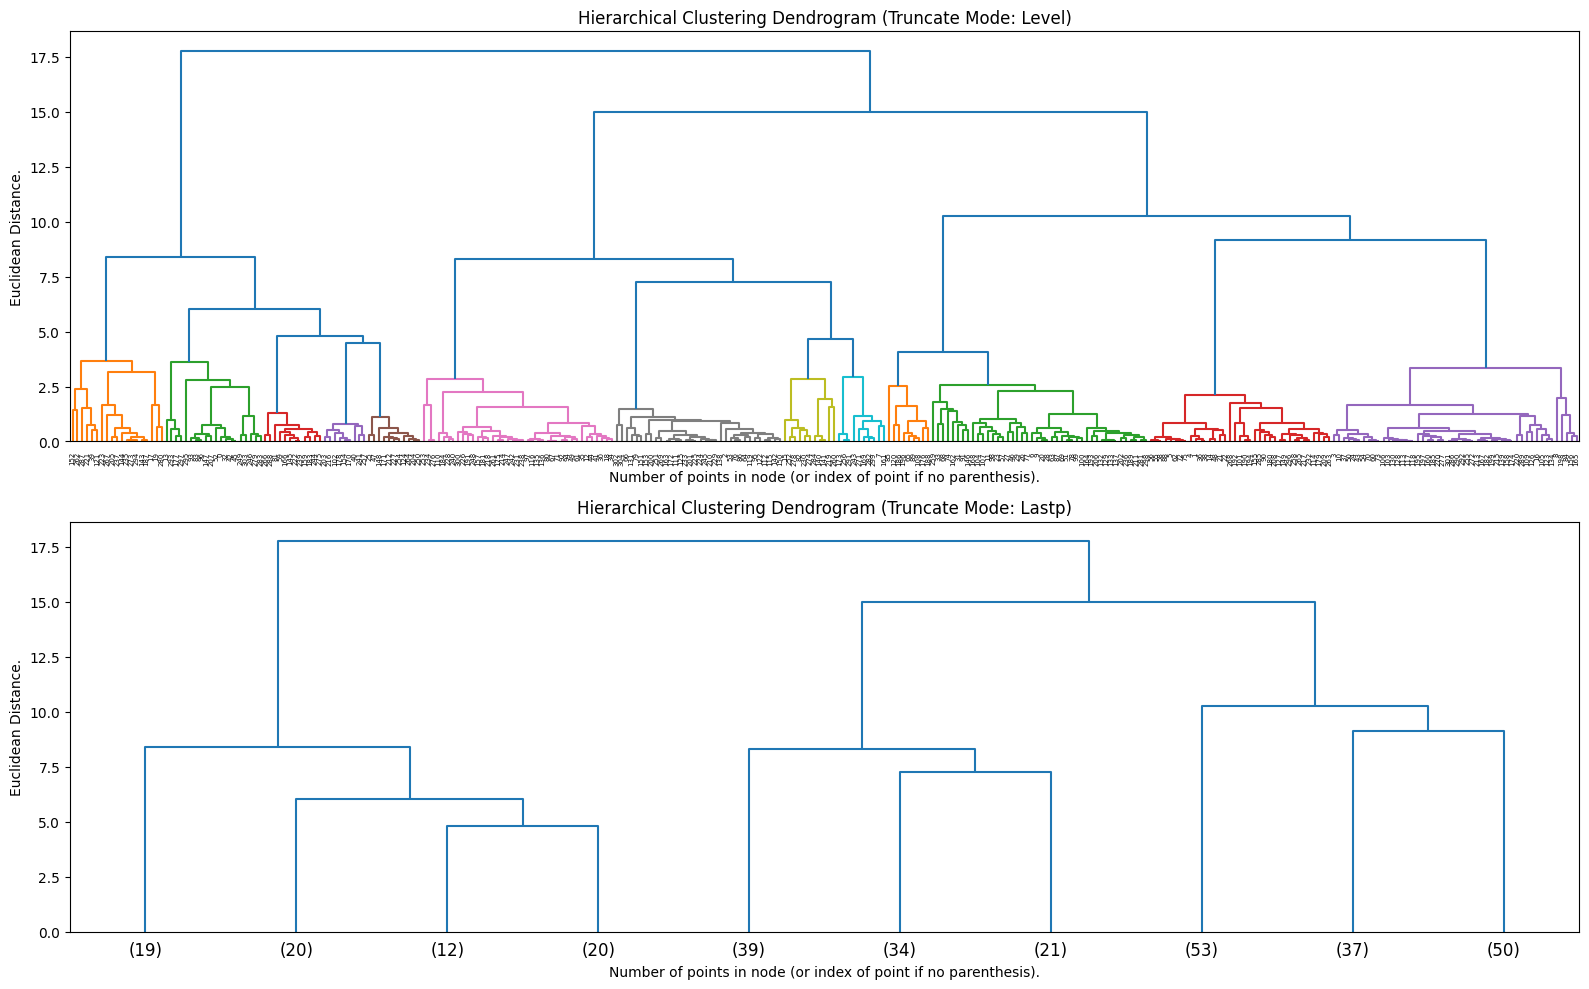

In [14]:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=df_scaled)

plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.title("Hierarchical Clustering Dendrogram (Truncate Mode: Level)")
dm.plot_dendrogram(modelo_hclust_ward, color_threshold=3.75, truncate_mode='level')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Euclidean Distance.")

plt.subplot(2, 1, 2)
plt.title("Hierarchical Clustering Dendrogram (Truncate Mode: Lastp)")
dm.plot_dendrogram(modelo_hclust_ward, color_threshold=3.75, truncate_mode='lastp', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Euclidean Distance.")

plt.tight_layout()
plt.show()

In [15]:
cluster_model_final=KMeans(n_clusters=10,n_init= 20,random_state = 123)
cluster_model_final.fit(df_scaled)
joblib.dump(cluster_model_final,'model.sav')

['model.sav']

In [16]:
model=joblib.load('model.sav')
labels=model.predict(df_scaled)
df_sellers_raw['label']=labels
df_sellers_raw.to_csv('MELI_sellers.csv',sep=';',index=False)

In [17]:
df_sellers_raw.columns[df_sellers_raw.dtypes!='object']

Index(['seller_id', 'years_antiquity', 'n_items', 'n_subcategories',
       'sold_items', 'mean_intallments', 'q10_discount', 'q50_discount',
       'q90_discount', 'total_transactions', 'completed_transactions',
       'canceled_transactions', 'negative_rating', 'neutral_rating',
       'positive_rating', 'total_claims', 'total_delayed_shipments',
       'total_cancellations', 'gold_pro', 'gold_special', 'label'],
      dtype='object')

In [18]:
dm.cluster_characterization_numeric_var(df=df_sellers_raw,str_var='sold_items')

,grupo,cv_grupo,cv_total,dif%_cv,min,max,mean
0,0,1.915835,4.065467,-52.875416,0,1440,141.945946
1,1,2.702106,4.065467,-33.535166,0,755,50.588235
2,2,1.469537,4.065467,-63.853174,0,2250,392.200000
3,3,2.308035,4.065467,-43.228299,0,137,10.136364
4,4,2.789969,4.065467,-31.373959,0,13000,661.773585
5,5,2.102961,4.065467,-48.272588,0,500,50.081633
6,6,1.276975,4.065467,-68.589712,0,57,12.944444
7,7,0.784315,4.065467,-80.707883,5,1000,393.750000
8,8,2.983762,4.065467,-26.607153,0,383,31.562500
9,9,3.359309,4.065467,-17.369660,0,5000,317.500000


In [19]:
dm.cluster_characterization_numeric_var(df=df_sellers_raw,str_var='q90_discount')

,grupo,cv_grupo,cv_total,dif%_cv,min,max,mean
0,0,2.038173,2.292167,-11.080954,0.0,26.026026,2.865578
1,1,2.371985,2.292167,3.482203,0.0,35.000000,2.877802
2,2,1.741348,2.292167,-24.030486,0.0,8.000000,1.487996
3,3,2.499119,2.292167,9.028653,0.0,23.335926,2.410296
4,4,1.382735,2.292167,-39.675645,0.0,47.854022,10.573673
5,5,3.616972,2.292167,57.797058,0.0,46.324587,2.225183
6,6,3.741978,2.292167,63.250671,0.0,37.000000,2.333333
7,7,1.124880,2.292167,-50.925049,0.0,15.000000,4.166865
8,8,2.246953,2.292167,-1.972532,0.0,16.670140,1.948134
9,9,2.455087,2.292167,7.107660,0.0,27.669805,2.585773


In [20]:
df_sellers_raw.columns[df_sellers_raw.dtypes=='object']

Index(['seller_reputation+power_seller_status', 'seller_reputation+level_id',
       'seller_reputation+metrics+sales+period'],
      dtype='object')

In [21]:
dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+power_seller_status')

,label,Not_medal,gold,platinum,silver
0,0,0.0,1.0,0.00,0.00
1,1,1.0,0.0,0.00,0.00
2,2,0.0,0.0,0.45,0.55
3,3,1.0,0.0,0.00,0.00
4,4,0.0,0.0,1.00,0.00
5,5,0.0,0.0,0.00,1.00
6,6,1.0,0.0,0.00,0.00
7,7,0.0,1.0,0.00,0.00
8,8,1.0,0.0,0.00,0.00
9,9,1.0,0.0,0.00,0.00


In [22]:
dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+level_id')

,label,0_Not_type,1_red,2_orange,3_yellow,4_light_green,5_green
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,0.000000,0.022727,0.022727,0.068182,0.000000,0.886364
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,6,0.111111,0.000000,0.000000,0.000000,0.222222,0.666667
7,7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,8,0.000000,0.000000,0.000000,0.187500,0.812500,0.000000
9,9,0.000000,0.000000,0.000000,0.181818,0.000000,0.818182


In [23]:
dh.summarise_categoric_variable(df_sellers_raw,'label','seller_reputation+metrics+sales+period')

,label,365 days,60 days
0,0,0.000,1.000
1,1,0.000,1.000
2,2,0.000,1.000
3,3,1.000,0.000
4,4,0.000,1.000
5,5,0.000,1.000
6,6,1.000,0.000
7,7,0.000,1.000
8,8,0.375,0.625
9,9,0.000,1.000


In [24]:
dh.summarise_categoric_variable(df_sellers_raw,'seller_reputation+level_id','seller_reputation+power_seller_status')

,seller_reputation+level_id,Not_medal,gold,platinum,silver
0,0_Not_type,1.000000,0.000000,0.000000,0.000000
1,1_red,1.000000,0.000000,0.000000,0.000000
2,2_orange,1.000000,0.000000,0.000000,0.000000
3,3_yellow,1.000000,0.000000,0.000000,0.000000
4,4_light_green,1.000000,0.000000,0.000000,0.000000
5,5_green,0.375912,0.178832,0.226277,0.218978
